**Trích xuất thư viện**

In [38]:
# TensorFlow Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

# Scikit-learn
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR


# Các thư viện khác
from collections import Counter
from math import ceil
import pandas as pd
import numpy as np
import tensorflow as tf 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 

warnings.filterwarnings('ignore')

**Đọc dữ liệu**

In [39]:
train_directory = "../Human_emotion_dectection/data2/train"
test_directory = "../Human_emotion_dectection/data2/test"

In [40]:
class_labels = {
    0: 'Angry',
    1: 'Happy',
    2: 'Sad',
    3: 'Nothing'
}

**Tiền xử lý dữ liệu**

In [41]:
# Dùng ImageDataGenerator để load và tiền xử lý ảnh
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
train_generator = train_datagen.flow_from_directory(train_directory, target_size=(48, 48),
                                                    color_mode='grayscale', batch_size=32,
                                                    class_mode='sparse')

class_counts_train = Counter(train_generator.classes)
print("Thống kê số lượng hình ảnh trong mỗi lớp (train):")
for class_label, count in class_counts_train.items():
    print(f"{class_labels[class_label]}: {count} ảnh")

test_generator = test_datagen.flow_from_directory(test_directory, target_size=(48, 48),
                                                  color_mode='grayscale', batch_size=32,
                                                  class_mode='sparse')

class_counts_test = Counter(test_generator.classes)
print("Thống kê số lượng hình ảnh trong mỗi lớp (test):")
for class_label, count in class_counts_test.items():
    print(f"{class_labels[class_label]}: {count} ảnh")

Found 3162 images belonging to 4 classes.
Thống kê số lượng hình ảnh trong mỗi lớp (train):
Angry: 860 ảnh
Happy: 830 ảnh
Sad: 874 ảnh
Nothing: 598 ảnh
Found 788 images belonging to 4 classes.
Thống kê số lượng hình ảnh trong mỗi lớp (test):
Angry: 213 ảnh
Happy: 207 ảnh
Sad: 219 ảnh
Nothing: 149 ảnh


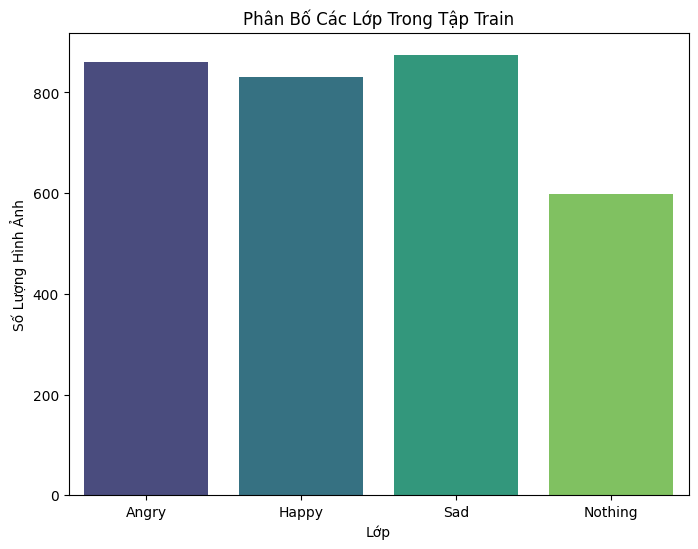

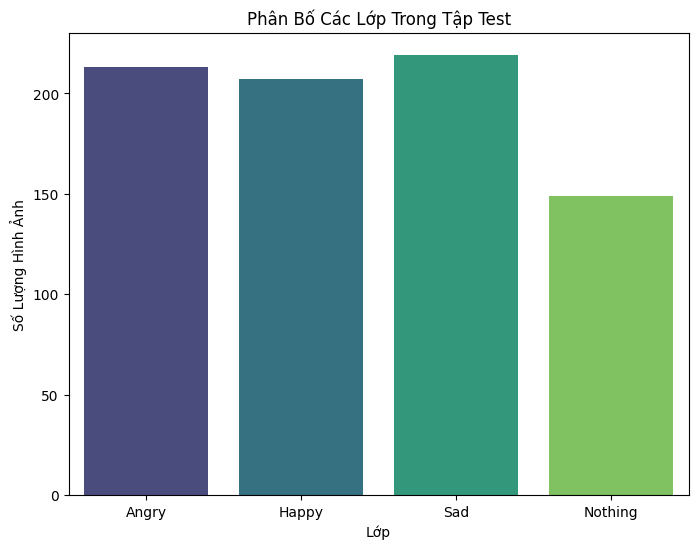

In [43]:
# Phân bố các lớp trong tập train
plt.figure(figsize=(8,6))
sns.barplot(x=list(class_labels.values()), y=[class_counts_train[i] for i in range(len(class_labels))], palette='viridis')
plt.title('Phân Bố Các Lớp Trong Tập Train')
plt.xlabel('Lớp')
plt.ylabel('Số Lượng Hình Ảnh')
plt.show()

# Phân bố các lớp trong tập test
plt.figure(figsize=(8,6))
sns.barplot(x=list(class_labels.values()), y=[class_counts_test[i] for i in range(len(class_labels))], palette='viridis')
plt.title('Phân Bố Các Lớp Trong Tập Test')
plt.xlabel('Lớp')
plt.ylabel('Số Lượng Hình Ảnh')
plt.show()

**Sử dụng CNN end-to-end**

In [44]:
def create_cnn_model(input_shape=(48, 48, 1), num_classes=4):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Dùng softmax cho phân loại đa lớp

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = create_cnn_model()

model.summary()

history = model.fit(train_generator, epochs=20, validation_data=test_generator)

model.save('emotion_recognition_cnn_model.h5')

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

test_images, test_labels = [], []
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    test_images.extend(x_batch)
    test_labels.extend(y_batch)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)

predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,460 (1.36 MB)

 Trainable params: 355,460 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.3983 - loss: 1.2552 - val_accuracy: 0.4721 - val_loss: 1.2658
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.5036 - loss: 1.0453 - val_accuracy: 0.5254 - val_loss: 1.0840
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.5299 - loss: 0.9904 - val_accuracy: 0.4772 - val_loss: 1.2045
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.5424 - loss: 0.9623 - val_accuracy: 0.5165 - val_loss: 1.1722
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.5644 - loss: 0.9252 - val_accuracy: 0.5838 - val_loss: 0.9017
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.5600 - loss: 0.9310 - val_accuracy: 0.5888 - val_loss: 0.9231
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.5697 - loss: 0.9053 - val_accuracy: 0.5799 - val_loss: 0.9310
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.5677 - loss: 0.8809 - val_accu

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6776 - loss: 0.8401
Test accuracy: 0.6700507402420044
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.50      0.55       213
         1.0       0.55      0.81      0.65       207
         2.0       0.87      1.00      0.93       219
         3.0       0.59      0.23      0.34       149

    accuracy                           0.67       788
   macro avg       0.66      0.64      0.62       788
weighted avg       0.67      0.67      0.64       788

Accuracy: 0.6700507614213198


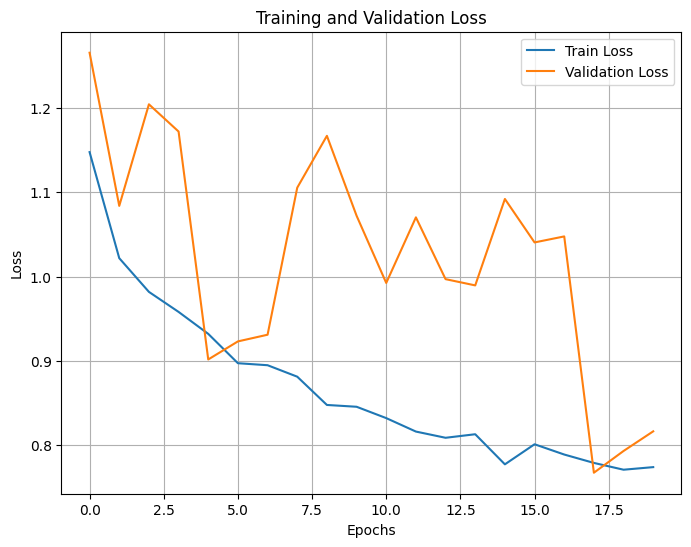

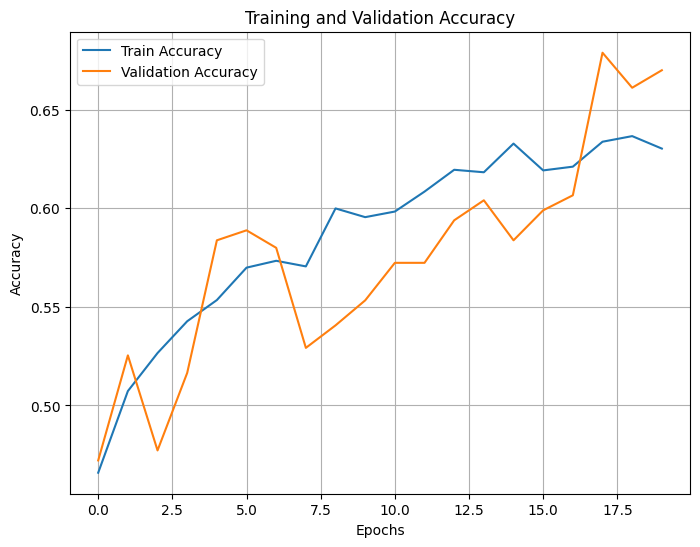

In [45]:
# Hiển thị biểu đồ loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')  # Loss trên tập huấn luyện
plt.plot(history.history['val_loss'], label='Validation Loss')  # Loss trên tập validation
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Vẽ biểu đồ Train Accuracy và Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Sử dụng CNN trích xuất đặc trưng**

In [46]:
def create_cnn_feature_extractor(input_shape=(48, 48, 1)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))

    return model

feature_extractor = create_cnn_feature_extractor()

feature_extractor.summary()

train_datagen = ImageDataGenerator(rescale=1./255)

train_directory = "../Human_emotion_dectection/data2/train" 

train_generator = train_datagen.flow_from_directory(train_directory, target_size=(48, 48),
                                                    color_mode='grayscale', batch_size=32,
                                                    class_mode="sparse", shuffle=False)


features = feature_extractor.predict(train_generator, verbose=1)

np.save('train_features.npy', features)

print("Shape of extracted features:", features.shape)



test_directory = "../Human_emotion_dectection/data2/test" 

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_directory, target_size=(48, 48),
                                                 color_mode='grayscale', batch_size=32,
                                                 class_mode="sparse", shuffle=False)

test_features = feature_extractor.predict(test_generator, verbose=1)

np.save('test_features.npy', test_features)

print("Shape of extracted test features:", test_features.shape)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,944 (1.35 MB)

 Trainable params: 354,944 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Found 3162 images belonging to 4 classes.
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step
Shape of extracted features: (3162, 128)
Found 788 images belonging to 4 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Shape of extracted test features: (788, 128)


**LDA + KNN**

In [47]:
train_features = np.load('train_features.npy') 
train_labels = np.array(train_generator.classes)

test_features = np.load('test_features.npy')
test_labels = np.array(test_generator.classes)

lda = LDA(n_components=2)  
train_features_lda = lda.fit_transform(train_features, train_labels)
test_features_lda = lda.transform(test_features)  

plt.figure(figsize=(8, 6))
plt.scatter(train_features_lda[:, 0], train_features_lda[:, 1], c=train_labels, cmap='plasma', edgecolors='k', alpha=0.7)
plt.title('LDA: Dữ liệu huấn luyện sau khi giảm chiều', fontsize=14)
plt.xlabel('LDA Component 1', fontsize=12)
plt.ylabel('LDA Component 2', fontsize=12)
plt.colorbar(label='Class Labels') 
plt.show()

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(train_features_lda, train_labels)

test_predictions = knn.predict(test_features_lda) 

print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))

test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy(k=5):", test_accuracy)

**PCA + SVM**

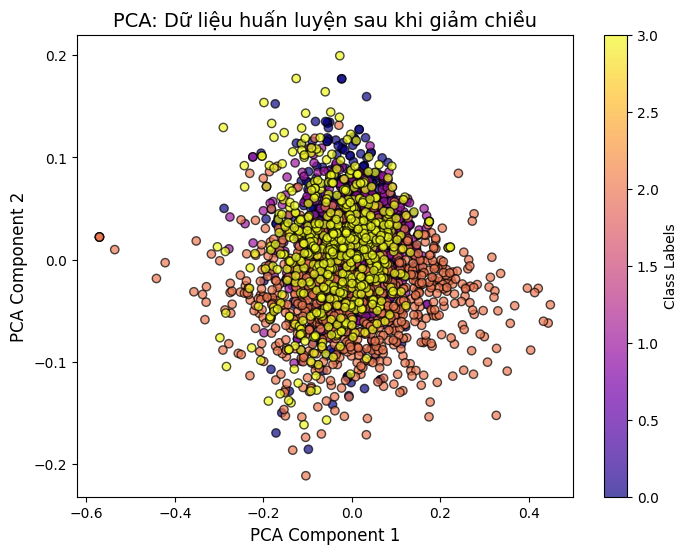

Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       213
           1       0.58      0.71      0.64       207
           2       0.91      0.93      0.92       219
           3       0.49      0.36      0.42       149

    accuracy                           0.66       788
   macro avg       0.64      0.64      0.63       788
weighted avg       0.65      0.66      0.65       788

Test Accuracy: 0.6598984771573604


In [48]:
train_features = np.load('train_features.npy')
train_labels = np.array(train_generator.classes) 

test_features = np.load('test_features.npy') 
test_labels = np.array(test_generator.classes) 

pca = PCA(n_components=100) 
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features) 

plt.figure(figsize=(8, 6))
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c=train_labels, cmap='plasma', edgecolors='k', alpha=0.7)
plt.title('PCA: Dữ liệu huấn luyện sau khi giảm chiều', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(label='Class Labels')
plt.show()

svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True, decision_function_shape='ovr')
svm.fit(train_features_pca, train_labels)

test_predictions = svm.predict(test_features_pca)
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))
print("Test Accuracy:", accuracy_score(test_labels, test_predictions))

**SVR**

In [49]:
train_probas = svm.predict_proba(train_features_pca)
test_probas = svm.predict_proba(test_features_pca)

selected_class = 2  # Chọn phân lớp "Sad"

y_train = train_probas[:, selected_class]
y_test = test_probas[:, selected_class]

svr_model = SVR(kernel='rbf', C=1, gamma='scale')
svr_model.fit(train_features_pca, y_train)

y_pred = svr_model.predict(test_features_pca)
y_pred = np.clip(y_pred, 0, 1)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Hồi quy SVR trên phân lớp 'Sad' ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


=== Hồi quy SVR trên phân lớp 'Sad' ===
Mean Squared Error (MSE): 0.0083
Mean Absolute Error (MAE): 0.0588
R² Score: 0.9487


In [50]:
# # Lấy xác suất của các lớp từ SVM
# test_probas = svm.predict_proba(test_features_pca)

# selected_class = 2
# sad_probas = test_probas[:, selected_class]

# indices_sad = np.where(test_labels == selected_class)[0]
# np.random.seed(42)
# ground_truth_sad_orig = np.random.uniform(50, 100, size=len(indices_sad))

# y_reg_norm = (ground_truth_sad_orig - 50) / 50

# X_reg = sad_probas[indices_sad].reshape(-1, 1)
# y_reg = y_reg_norm

# svr_model = SVR(kernel='rbf', C=1, gamma='scale')
# svr_model.fit(X_reg, y_reg)
# y_pred_norm = svr_model.predict(X_reg)

# mse_norm = mean_squared_error(y_reg, y_pred_norm)
# mae_norm = mean_absolute_error(y_reg, y_pred_norm)
# r2_norm = r2_score(y_reg, y_pred_norm)

# print("\n=== Hồi quy với SVR ===")
# print("Mean Squared Error (MSE):", mse_norm)
# print("Mean Absolute Error (MAE):", mae_norm)
# print("R² Score:", r2_norm)


In [51]:
# plt.figure(figsize=(8,6))
# plt.scatter(y_reg, y_pred_norm, color='blue', alpha=0.7, edgecolor='k', label='Samples')
# min_val = min(np.min(y_reg), np.min(y_pred_norm))
# max_val = max(np.max(y_reg), np.max(y_pred_norm))
# plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
# plt.xlabel("Ground Truth (Normalized)", fontsize=12)
# plt.ylabel("Predicted Value (SVR output, Normalized)", fontsize=12)
# plt.title("So sánh Ground Truth và Dự đoán (Hồi quy SVR) cho lớp 'Sad'", fontsize=14)
# plt.legend()
# plt.grid(True)
# plt.show()

**Trực quan SVR**

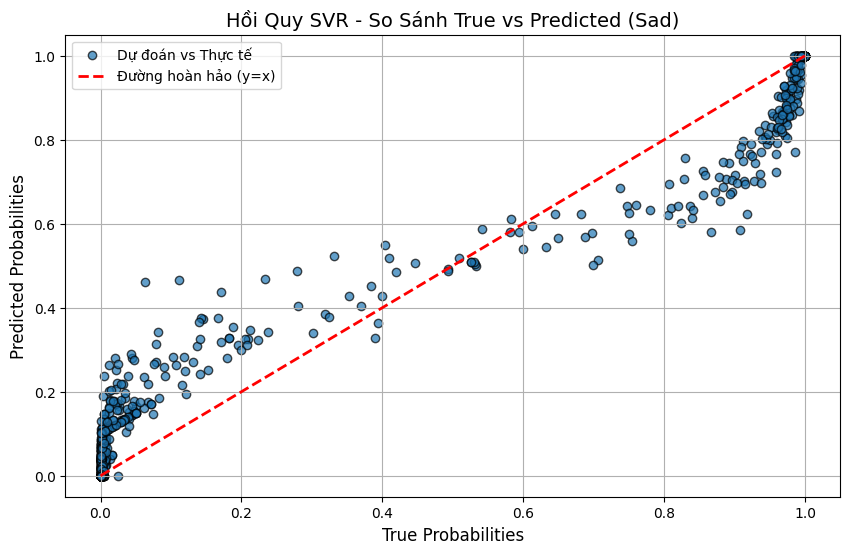

In [52]:
# Vẽ biểu đồ so sánh giữa nhãn thực tế và giá trị dự đoán
def visualize_regression_results(y_true, y_pred, class_label):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k', label='Dự đoán vs Thực tế')
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Đường hoàn hảo')
    
    plt.title(f'Hồi Quy SVR ({class_label})', fontsize=14)
    plt.xlabel('True Probabilities', fontsize=12)
    plt.ylabel('Predicted Probabilities', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_regression_results(y_test, y_pred, class_labels[selected_class])


**Hồi quy KNN**

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor


train_probas = svm.predict_proba(train_features_pca)
test_probas = svm.predict_proba(test_features_pca)

selected_class = 2 

# Lấy xác suất của phân lớp "Sad" làm nhãn mới cho bài toán hồi quy
y_train = train_probas[:, selected_class]
y_test = test_probas[:, selected_class]

knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'] 
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(train_features_pca, y_train)

best_knn = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

y_pred_knn = best_knn.predict(test_features_pca)

mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("\n=== Hồi quy KNN trên phân lớp 'Sad' ===")
print(f"Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_knn:.4f}")
print(f"R² Score: {r2_knn:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

=== Hồi quy KNN trên phân lớp 'Sad' ===
Mean Squared Error (MSE): 0.0517
Mean Absolute Error (MAE): 0.0928
R² Score: 0.6804
